In [172]:
# import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# Read and Load Datasets

In [167]:
# file paths
atac_path = 'Tab_delimited_text\Hackathon2024.ATAC.txt.gz'
rna_path = 'Tab_delimited_text\Hackathon2024.RNA.txt.gz'
meta_path = 'Tab_delimited_text\Hackathon2024.Meta.txt.gz'
training_path = 'Tab_delimited_text\Hackathon2024.Training.Set.Peak2Gene.Pairs.txt.gz'
testing_path = 'Tab_delimited_text\Hackathon2024.Testing.Set.Peak2Gene.Pairs.txt.gz'

In [168]:
def read_df(df_path,keys):
    tdf = pd.read_csv(df_path, sep='\t')
    tdf = tdf.set_index(keys, drop=True)
    return tdf

atac_df = read_df(atac_path, 'peak')
rna_df = read_df(rna_path,'gene')

In [169]:
meta_df = pd.read_csv(meta_path, sep='\t')
training_df = pd.read_csv(training_path, sep='\t')
testing_df = pd.read_csv(testing_path, sep='\t')

# Linear Regression

Every 'cell' is an observation of the peak and rna in that cell. 

For every pair of peak and gene, an ordinary least square regression checks for the statistical significance of their relationship. 

A statistical significance level 'alpha' is chosen whereby all p-values below this means that such a pair of peak and gene is valid.

This method is less prone to overfitting if the statistical significance level is chosen based on statistical theory.

In [161]:
# set statistical significant level
alpha = 0.005

## Prediction

In [162]:
# predict
def predict(df, alpha):
    pvalues = []

    for i in range(len(df)):
        cell = df.iloc[i]
        X = atac_df.loc[cell['peak']].to_frame()
        y = rna_df.loc[cell['gene']]

        X2 = sm.add_constant(X)
        est = sm.OLS(y, X2)
        est2 = est.fit()
        pvalues.append(est2.pvalues[1])

    # get p-values
    df['pvalues'] = pvalues

    # produce prediction
    df['y'] = df['pvalues'] < alpha

    return df

training_df = predict(df=training_df, alpha=alpha)
testing_df = predict(df=testing_df, alpha=alpha)

In [163]:
# check incorrect classification
training_df['check'] = training_df['Peak2Gene'] ^ training_df['y']
print('number of misclassifications =', sum(training_df['check']))

number of misclassifications = 0


## Visualize

In [164]:
def addlabels(x, y):
    for i in range(len(x)):
        if y[i] < 0.02 and y[i] > 0.001:
            plt.text(i,y[i],round(y[i],4))

def plot(df, alpha):
    plt.figure(figsize=(12,9))
    plt.ylim(0, 0.02)
    plt.hlines(0.001, 0, 299, colors=['red'], linestyles='dashed')
    plt.hlines(0.019, 0, 299, colors=['red'], linestyles='dashed')
    plt.hlines(alpha, 0, 299, colors=['orange'])
    plt.plot(range(len(df)), df['pvalues'],linestyle='',marker='o',markerfacecolor='None')
    addlabels(range(len(df)), df['pvalues'])

Text(0.5, 1.0, 'P-Values, OLS, training set, first 150 is TRUE')

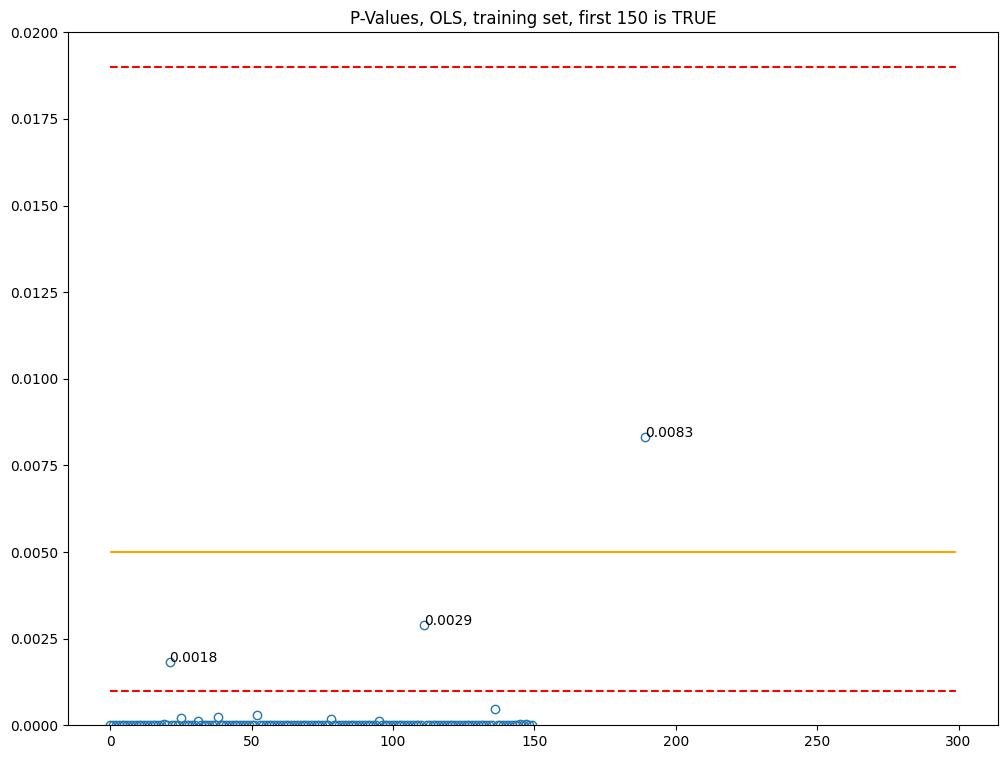

In [165]:
plot(df=training_df, alpha=alpha)
plt.title('P-Values, OLS, training set, first 150 is TRUE')

Text(0.5, 1.0, 'P-Values, OLS, testing set, sorted')

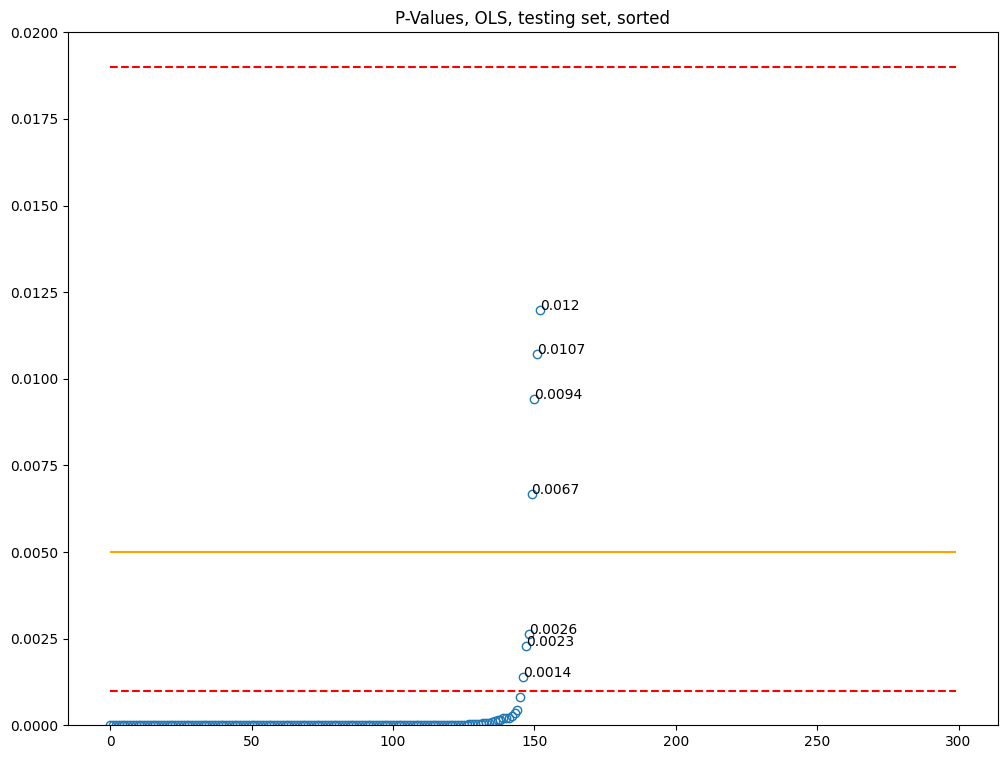

In [166]:
testing_df = testing_df.sort_values('pvalues').reset_index()
plot(df=testing_df, alpha=alpha)
plt.title('P-Values, OLS, testing set, sorted')